In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [18]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [19]:
### exact same code from previous lesson
chars = sorted(list(set(''.join(words))))
stoi = {s : i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()}
vocab_size = len(itos)
block_size = 3 #content length, from how much do we want to predict next char

def build_dataset(iwords):  
    X, Y = [], []
    for w in iwords:
        # print(w)
        context = [0] * block_size #outputs [0,0,0]
        for chr in w + '.':
            ix = stoi[chr]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context) + ' ----> ' + itos[ix])
            context = context[1:] + [ix] #creating new list with new char appended to finish

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(1)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xval, Yval = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%

torch.Size([182254, 3]) torch.Size([182254])
torch.Size([22914, 3]) torch.Size([22914])
torch.Size([22978, 3]) torch.Size([22978])


In [69]:
n_embd = 10
n_hidden = 200


C = torch.randn(vocab_size, n_embd) # deconstructed matrix 

#if the values that tanh func receives are way too much big, tanh output for its grad value for passing it to subsequint backward propogation functions
#is becomes complete 0.
#due to chain rule of backpropogation every other grad value of neurons received from this spesific neuron also becomes 0.
#it means that neuron will not convey any info to its susequient neuron which is basically dead neuron for that single piece of data
#dead neuron situation can occur on making randomized weights value has sparking values or learning rate is too much high that tanh value becomes too large.
#we properly say that changing slightly of the value for tanh neuron would not change any values to its subsequient neurons whatsoever.
#for visualizing this phenonomena, imagine the values you get from tanh neuron are waaay to much in the linear sides of graph of tanh

#so we want to make weights as uniform and have little bit of jiggle value to add some randomness to weights. how much jiggle? that is definition of standart deviation
#you want to have stand dev of 1 for the output of values come from tanh. so what we do is, getting kaimu normalization that makes makes output of tanh starndart dev to be 1
#https://arxiv.org/abs/1502.01852
#in paper standart dev is the number we multiply W1 with, 5/3 is tanh spesific gain, paper uses square root of 2 for relu
#in paper there is epsilon value for stad dev to add, we dont need it right now it prevents dividing by 0 but can be implemented
#torch has this norm func implemented 

W1 = torch.randn(n_embd * block_size, n_hidden) * (5 / 3) / ((n_embd * block_size)**0.5) #before it was 0.2

#no need because this has normbatch, meaning biases will cancel out when we subtract from mean. see below for expl.
# B1 = torch.randn(n_hidden) * 0.01

#during initiliazation, since values of w2 and b2 are completely random, the initial loss becomes very high
#we would want initial loss to be near but not exact to random guessing which in our case would be -log(1/27)
#because we want all of the iterations all of the steps to not to fix the current initial burst of loss but want to have loss that would be
#much easier to fix to have much more iteration to fix it
#there would be much more steps for neurons to be trained for
W2 = torch.randn(n_hidden, vocab_size) * 0.01
B2 = torch.randn(vocab_size) * 0

bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)

#these are zerso and ones because initilaly we pass very gauisann values to it with have means of 0 and stad dev of 1 
bnmean_running = torch.zeros(1, n_hidden)
bnstad_running = torch.ones(1, n_hidden)


params = [C, W1, B1, W2, B2, bngain, bnbias]
for p in params:
    p.requires_grad = True
total_params = sum(n.nelement() for n in params)
print(total_params)

#general tip, above problem can be easily solved in our small network but for prod environment, this problem may have caused our network to not decrease loss properly at all
#the bigger the network becomes, the less forgiving these kinds of problems become. 


12297


In [70]:
steps = 100000
batch_s = 32
lossi = []
for i in range(steps):

    #minibatch 
    ix = torch.randint(0, Xtr.shape[0], (batch_s, ))  
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y
    
    #forward pass
    emb = C[Xb] # (32, 3, 2) # embed the characters into vectors
    embcat = emb.view(emb.shape[0],-1) #contentacte vectors

    #we are wasting compute resource for calculating bias in here because below we take mean of hpreact and subtracting from it.
    #that means any addition of subtraction are canceled out. so no bias necessary
    
    hpreact = embcat @ W1 # + B1 # 32, 100 // pre activation of hidden layer
    #we want the values past on the tanh function not to be too big or too small, they need to have stand dev of 1.
    #so we can just normalize the values received from hpreact with stad dev of 1 and mean of 0 to get smoother values
    #BUT we want to do this in initilazation so we initilize them as 1s and 0s. then model itself can play with bngain and bnbias to shape up how normalization
    #should be working. it can do stand dev of 4 or mean of 3 as model continues to train 
    #bngain plays with stad dev and bnbias plays with mean
    #paper to explain it look at page 3 we do the exact same thing.
    #https://arxiv.org/pdf/1502.0317
    #these operations are completely differentiable so we are good.

    #my gut andrej says that he shot himself in the foot for too many time due to coupling nature of batches and normalizing them
    #he says try to avoid as much as possible
    #another approaches for normalizing batches are layer group normalizations, layer normalization

    bn_meani = hpreact.mean(0, keepdim=True)
    bn_stadi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bn_meani) / bn_stadi + bnbias 

    #however there is problem with this implementation. if we want to evaluate single example loss func, we cant becuase all of out training are
    #coupled up with batches and their normalized values. so while model is running, we should be calculating mean value of hpreact.mean(0, keepdim=True)
    #and stad dev of hpreact.std(0, keepdim=True) for all of the iteration of batches. sounds weird but it does make sense.
    #we would not want our examples to be coupled with batche normalization for the single example we pass in to.


    #running values will receive small update in direction of current batch of mean and stad
    with torch.no_grad():#we dont want these values to be changed during backward propagation.

        #the value selecte for 0.001 makes sense for our batch size because since it is very small, mean and stad dev can have very much
        #different values and small contribution to overall mean would be ok for reaching overall mean and stad dev.
        #0,001 called momentum and if it is too big, (torch batchnorm1d has default of 0,1 which is big for us), we might not get properly to
        #desired value because running mean and stad dev would change a lot for each batch.   

        bnmean_running = 0.999 * bnmean_running + 0.001 * bn_meani 
        bnstad_running = 0.999 * bnstad_running + 0.001 * bn_stadi



    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + B2 #output layer
    loss = F.cross_entropy(logits, Ytr[ix]) #loss function

    #backward pass
    for p in params:
        p.grad = None
    loss.backward() # back propogration

    lr = 0.1 if i < steps / 2 else 0.01
    for p in params:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i=}/{steps=}=={loss.item():.4f}')
    lossi.append(loss.log10().item())

    



i=0/steps=100000==3.2795
i=10000/steps=100000==2.2619
i=20000/steps=100000==2.2588
i=30000/steps=100000==2.2130
i=40000/steps=100000==1.7725
i=50000/steps=100000==2.3125
i=60000/steps=100000==2.2588
i=70000/steps=100000==2.4194
i=80000/steps=100000==2.1246
i=90000/steps=100000==1.9776


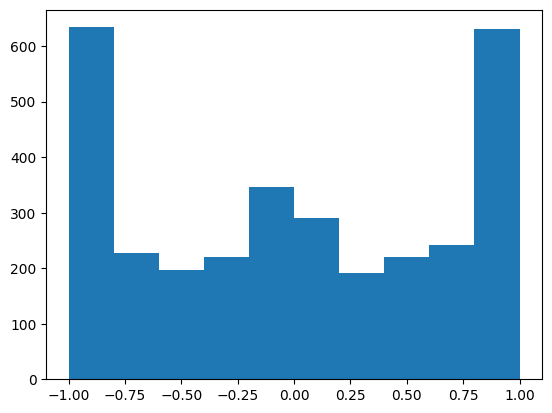

In [54]:
#tip 1 you can clear text output of plot with ; putting at end
#we are constructing this and subsequient graphs for single batch of example
#when we dont make our values that is inserted to tanh to near 0, we get lots of -1 and 1 values at init meaning their grad values will be 0
#but when its weights and biases are near 0 (in our case its W1 and B1), tanh activation values are distributed in the graph
#but when it doesnt, there are two big towers around -1 and 1. when you see this as a seniour machine learning expert, you may want to sweat :)
#to understand why this is detrimental, see above 

plt.hist(h.view(-1).tolist()); 

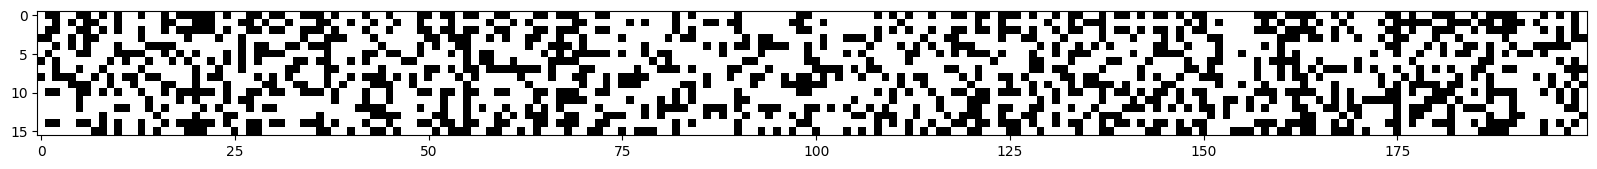

In [32]:
#when we not initilize weights of w1 and b1 which correspond to tanh activiations to near 0, we get spikes of values for tanh
#if one column of this graph becomes complete white, it means we have dead neuron that is not able to learn or pass any grad info to its pear neurons
#but if at least one neuron is firing up, it means it will learn something because it can properly, even for that one single data pass, grad value
#to subsequent neurons.
#w.grad value of tanh becomes 0 so this can be thought as brain damage of the person.
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray')



In [72]:
@torch.no_grad() #tells torch this func will not use any grad computation, basically disables grad.required to false to every variable. efficient
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (size of set, context-length, n_embd)
    embcan = emb.view(emb.shape[0], -1) # (size of set, context-length * n_embd)  concatting embeddings
    hpreact = embcan @ W1  #  (size of set, n_hidden) pre activation of hidden layer
    hpreact = bngain * (hpreact - bnmean_running) / bnstad_running + bnbias 
    h = torch.tanh(hpreact) # (size of set, n_hidden) hidden layer
    logits = h @ W2 + B2 # (size of set, vocab size) output layer
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.0910446643829346
val 2.130945920944214


In [1]:
for _ in range(20):
    out = []

    context = [0] * block_size 
    while True:
        emb = C[torch.tensor([context])] # 1, block size, embsize
        h = torch.tanh(emb.view(emb.shape[0], -1) @ W1) # 1, n hidden
        logits = h @ W2 + B2 # (1, vocab size)  
        prob = torch.softmax(logits, dim=1)
        ix = torch.multinomial(prob, num_samples=1).item()
        context = context[1:] + [ix]  
        out.append(ix)
        
        if(ix == 0):
            break
        
    print(''.join(itos[i] for i in out))


NameError: name 'block_size' is not defined

In [ ]:
####================NOW PRODUCTION LEVEL, "TORCHIFIED" Version of our mlp====================####

In [190]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(fan_in, fan_out) #/ fan_in**0.5 by introducing batchnorm, this initial normalization is not much necessary
        self.bias = torch.zeros(fan_out) if bias else None 

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        #keyword of 'is' is so cool
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self,dim, momentum=0.1, eps=10**-5):
        self.training = True #are we doing training or val or test?
        self.momentum = momentum
        self.eps = eps
        self.bngain = torch.ones(dim)
        self.bnbias = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True) 
            xvar = x.var(0, keepdim=True) 
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xres = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.bngain * xres + self.bnbias
        
        if self.training:
            with torch.no_grad():
                self.running_mean  = (1 - self.momentum) * self.running_mean + self.momentum * xmean 
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.bnbias, self.bngain]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self): #just adding this self made error go away
        # TypeError: Tanh.parameters() takes 0 positional arguments but 1 was given
        return []
 
n_embd = 10
n_hidden = 100
vocab_size = len(itos)
block_size = 3

C = torch.randn(vocab_size, n_embd)
layers = [Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
          ]
with torch.no_grad():
    #last layer / making output more soft and less confident in init
    # layers[-1].weight *= 0.1
    #when we introduce batchnorm, last layer is batchnorm so we should play with 
    layers[-1].bngain *= 0.1

    #every element except last 
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            #by introducing batchnorm, this initial normalization is not much necessary
            # layer.weight *= 5 / 3 #adding gain for tanh spesific, torch doesnt do this by default.
            layer.weight *= 1 
            #https://pytorch.org/docs/stable/nn.init.html
            #paper for kaimu also follows this gain but for relu which is square root of 2

#double list comprehension
params = [C] + [p for layer in layers for p in layer.parameters()]
print(f'NUmber of parameters created: {sum(p.nelement() for p in params)}')
count = 0
for p in params:
    p.requires_grad = True


NUmber of parameters created: 47551


In [191]:
steps = 100000
batch_s = 32
lossi = []
ud = []
for i in range(steps):

    #minibatch 
    ix = torch.randint(0, Xtr.shape[0], (batch_s, ))  
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y
    
    #forward pass
    emb = C[Xb] # (batch_s, block-size, n-embed) # embed the characters into vectors
    x = emb.view(emb.shape[0],-1) #contentacte vectors
    for layer in layers:
        x = layer(x)
    #x, when for loop finished will be output layer
    loss = F.cross_entropy(x, Ytr[ix]) #loss function

    for layer in layers:
        layer.out.retain_grad() #DEBUG PURPOSE

    #backward pass
    for p in params:
        p.grad = None
    loss.backward() # back propogration

    #i have seen from our learning rate grapgh that 0.1 should be 10x to meet our condition of 10**-3 average rate so 0.1 ==> 1
    lr = 1 if i < steps / 2 else 0.1
    for p in params:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i=}/{steps=}=={loss.item():.4f}')
    lossi.append(loss.log10().item())

    
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in params])


    # if i >= 1000:
    #     break   

i=0/steps=100000==3.2786
i=10000/steps=100000==2.2628
i=20000/steps=100000==2.5933
i=30000/steps=100000==2.2384
i=40000/steps=100000==1.9518
i=50000/steps=100000==2.1635
i=60000/steps=100000==2.0638
i=70000/steps=100000==2.4437
i=80000/steps=100000==2.2284
i=90000/steps=100000==2.0966


step:2 var:0.5600 mean:0.0029 stad:0.7483 saturated: 23.2188%  
step:5 var:0.5732 mean:0.0252 stad:0.7571 saturated: 20.9688%  
step:8 var:0.5978 mean:0.0118 stad:0.7731 saturated: 22.8438%  
step:11 var:0.6011 mean:-0.0334 stad:0.7753 saturated: 21.1562%  
step:14 var:0.6316 mean:0.0070 stad:0.7948 saturated: 27.2188%  


Text(0.5, 1.0, 'activation graph')

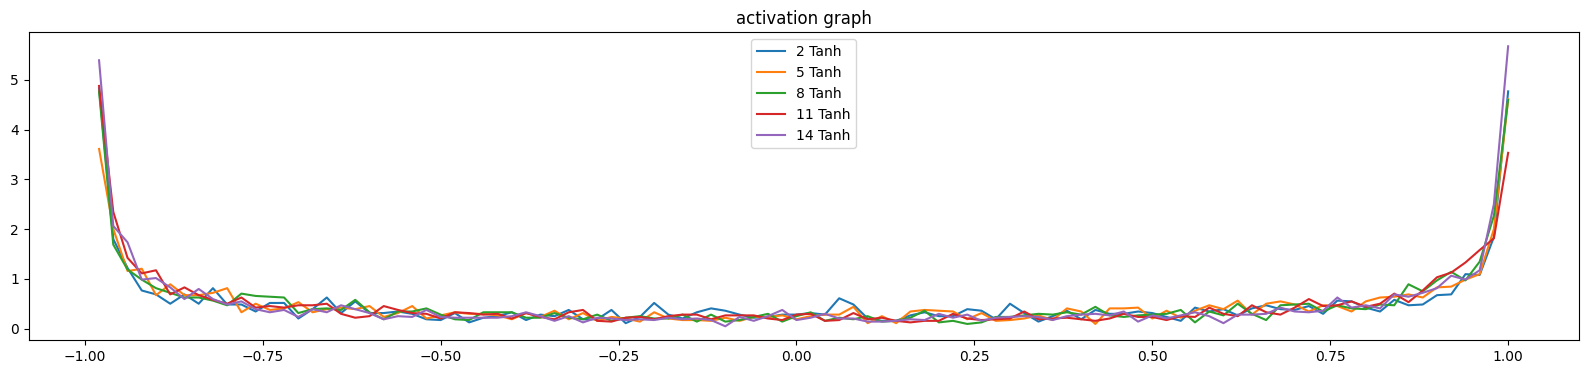

In [192]:
plt.figure(figsize=(20,4))
legends = []
#results we got here can be evaulated by passing break keyword for first ever batch.
#and looking at their saturation and variance values. 
#5/3 gain is perfect balance for gain addition to weight in initilization because
'''
5/3 gain values:
step:1 var:0.5539 mean:-0.0153 stad:0.7443 saturated: 17.7812%  
step:3 var:0.4688 mean:-0.0125 stad:0.6847 saturated: 9.7812%  
step:5 var:0.4380 mean:-0.0107 stad:0.6618 saturated: 7.7812%  
step:7 var:0.4369 mean:0.0473 stad:0.6610 saturated: 6.6250%  
step:9 var:0.4160 mean:-0.0240 stad:0.6450 saturated: 4.8438%  
1 gain values:
step:1 var:0.3383 mean:0.0189 stad:0.5816 saturated: 2.5312%  
step:3 var:0.2210 mean:0.0203 stad:0.4701 saturated: 0.0938%  
step:5 var:0.1598 mean:-0.0003 stad:0.3997 saturated: 0.0000%  
step:7 var:0.1222 mean:-0.0063 stad:0.3495 saturated: 0.0000%  
step:9 var:0.1049 mean:-0.0025 stad:0.3238 saturated: 0.0000% 
2 values
step:1 var:0.6428 mean:-0.0163 stad:0.8017 saturated: 29.5625%  
step:3 var:0.5633 mean:-0.0244 stad:0.7505 saturated: 18.1250%  
step:5 var:0.5382 mean:0.0102 stad:0.7336 saturated: 17.4375%  
step:7 var:0.5372 mean:0.0127 stad:0.7330 saturated: 16.7188%  
step:9 var:0.5306 mean:0.0156 stad:0.7284 saturated: 16.8750%  
'''
#var values of 1 is gradually decreasing, all values slowly converge to 0 which we dont want, we want some varience over
#all of the values of tanh activiations
#var values of 2 is stable and in fairly good number but saturations are way to much. this means from those neurons network's
#learning ability will halt since grad passed to other neurons from chain rule is basiccly 0
#5/3 is fairly in good position in terms of saturation and variance. doesnt have much sat with batch normalization and have stable and good var 




for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'step:{i} var:{t.var():.4f} mean:{t.mean():.4f} stad:{t.std():.4f} saturated: {((t.abs() > 0.97).float().mean() * 100):.4f}%  ')
        hy, hx = torch.histogram(t, density=True)
        legends.append(f'{i} {layer.__class__.__name__}')
        plt.plot( hx[1:].detach(), hy.detach())
plt.legend(legends)
plt.title('activation graph')
    


step:2 var:0.0000 mean:0.0000 stad:0.0038
step:5 var:0.0000 mean:0.0000 stad:0.0037
step:8 var:0.0000 mean:0.0000 stad:0.0034
step:11 var:0.0000 mean:-0.0000 stad:0.0034
step:14 var:0.0000 mean:0.0000 stad:0.0039


Text(0.5, 1.0, 'activation graph')

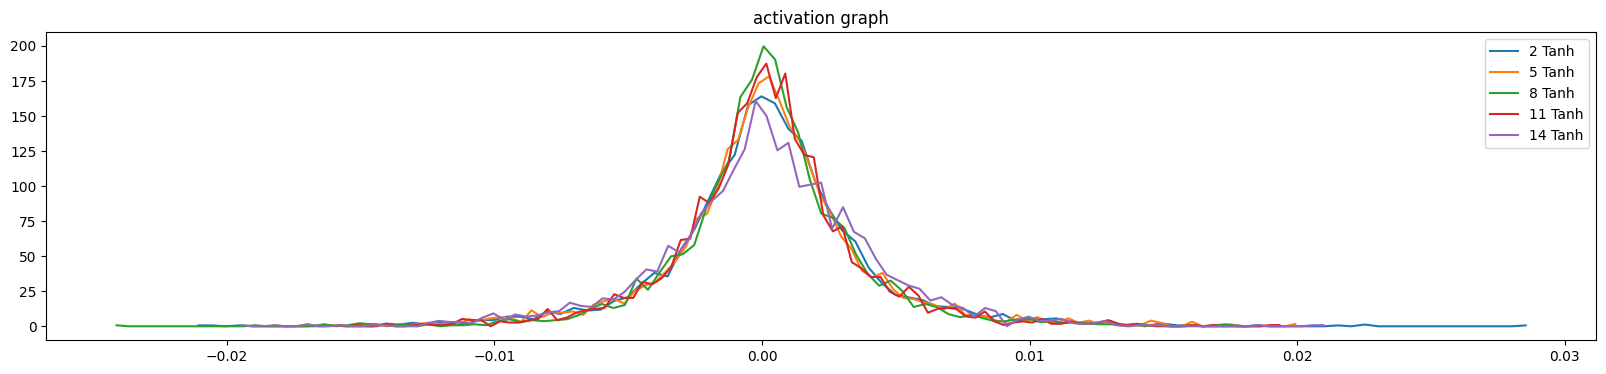

In [193]:
#we want to see in this grapgh is that grad values are not shrinking or exploding. every layer should have approximetly same grad values
#for first batch with gain 5/3 it is good
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'step:{i} var:{t.var():.4f} mean:{t.mean():.4f} stad:{t.std():.4f}')
        hy, hx = torch.histogram(t, density=True)
        legends.append(f'{i} {layer.__class__.__name__}')
        plt.plot( hx[1:].detach(), hy.detach())
plt.legend(legends)
plt.title('activation graph')


weights:(27, 10) std:0.0072 mean:-0.0000 data/grad ratio:-358407264.0  
weights:(30, 100) std:0.0034 mean:-0.0000 data/grad ratio:25.330259323120117  
weights:(100, 100) std:0.0015 mean:0.0000 data/grad ratio:-1186.929931640625  
weights:(100, 100) std:0.0015 mean:0.0000 data/grad ratio:103.888916015625  
weights:(100, 100) std:0.0013 mean:-0.0000 data/grad ratio:-442.60595703125  
weights:(100, 100) std:0.0013 mean:-0.0000 data/grad ratio:-4647.1416015625  
weights:(100, 27) std:0.0028 mean:-0.0000 data/grad ratio:2968.469970703125  


Text(0.5, 1.0, 'weights gradient distribution')

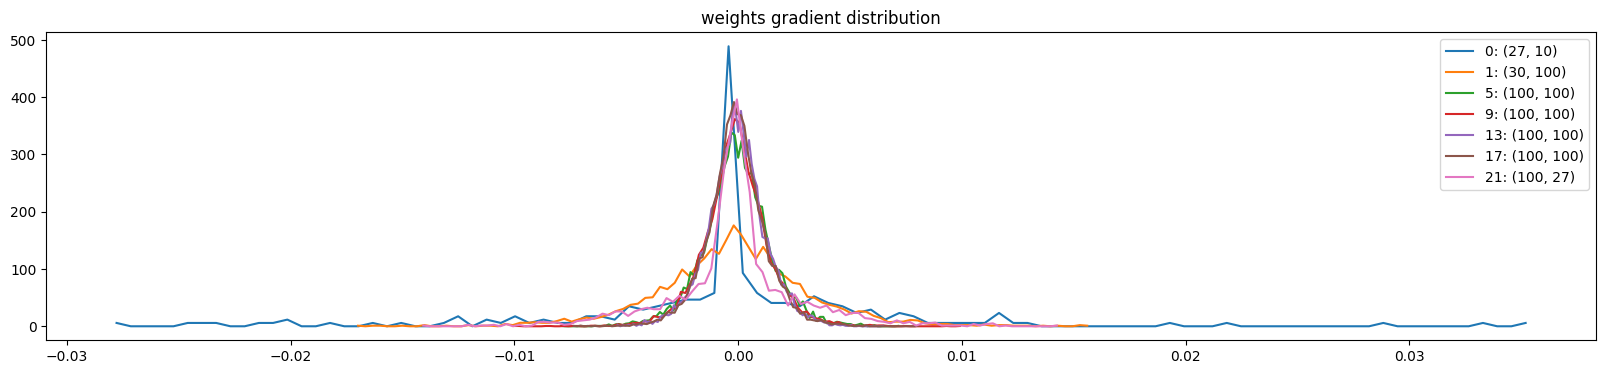

In [194]:
#last layer has some biiig contribution to overall learning
#last layer will be trained 10 times faster than every other layer at initilazation. later on this effect kinda fixes itself...

plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(params):
    g = p.grad
    if p.ndim == 2:
        print(f'weights:{tuple(p.shape)} std:{g.std():.4f} mean:{g.mean():.4f} data/grad ratio:{p.mean() / g.mean()}  ')
        hy, hx = torch.histogram(g, density=True) 
        legends.append(f'{i}: {tuple(p.shape)}')
        plt.plot( hx[:-1], hy )
plt.legend(legends)
plt.title('weights gradient distribution')


torch.Size([100000, 25])


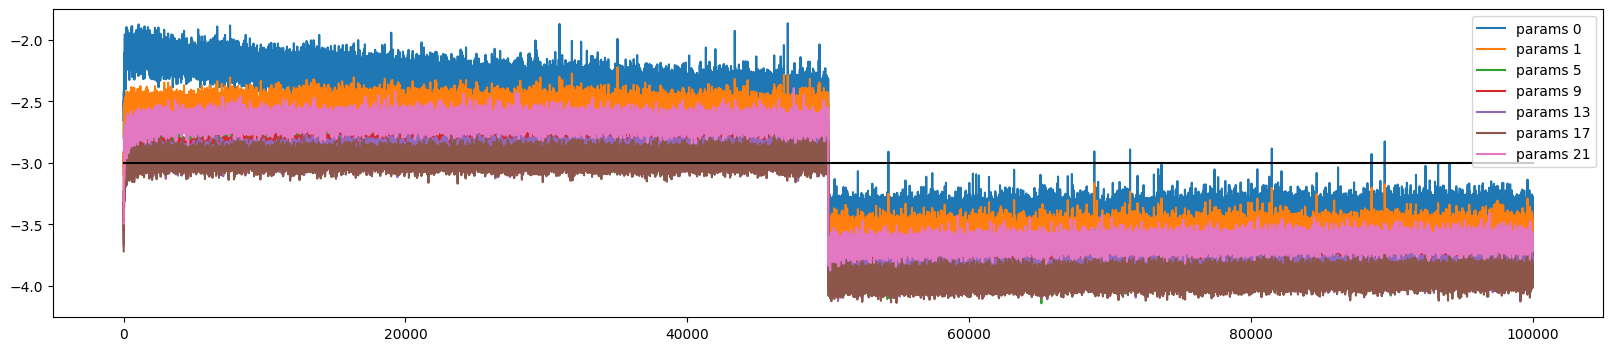

In [195]:
plt.figure(figsize=(20,4))
print(torch.tensor(ud).shape)
#the reason last layer is kind of outlier is we dont apply any gain and instead we multiply it by 0.1 that makes all of the weights too suspect to change  
legends = []
for i, p in enumerate(params):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'params {i}')
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be around 10**-3. in the black line limit  
#if lines are below black line, learning rate is too low if it is too high learning rate is too high 
#this graph is ok  
plt.legend(legends)


In [196]:
@torch.no_grad() #tells torch this func will not use any grad computation, basically disables grad.required to false to every variable. efficient
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (size of set, context-length, n_embd)
    embcan = emb.view(emb.shape[0], -1) # (size of set, context-length * n_embd)  concatting embeddings
    hpreact = embcan @ W1  #  (size of set, n_hidden) pre activation of hidden layer
    hpreact = bngain * (hpreact - bnmean_running) / bnstad_running + bnbias 
    h = torch.tanh(hpreact) # (size of set, n_hidden) hidden layer
    logits = h @ W2 + B2 # (size of set, vocab size) output layer
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


NameError: name 'W1' is not defined